In [2]:
import pandas as pd
import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mstats
import random
import lightgbm as lgb
import gc
import multiprocessing 
from sklearn.metrics import roc_auc_score
from pdpbox import pdp, info_plots
import shap
from sklearn.model_selection import KFold

In [4]:
df = pd.read_csv('../input/d/luyangshang/finance/data.csv')
df = df.drop(columns = ['Unnamed: 0'])

In [5]:
df = df.set_index('id')

# train test split

In [7]:
id_lst = df.index.unique().tolist()
random.shuffle(id_lst)
train_id = id_lst[:int(len(id_lst)*0.7)]
test_id = id_lst[int(len(id_lst)*0.7):]
train = df.loc[train_id]
test = df.loc[test_id]

In [17]:
train['defaulted']

id
6791721217    0
6791721217    0
4606460634    0
4606460634    0
4606460634    0
             ..
1017420330    0
1017420330    0
1017420330    0
1017420330    0
1017420330    0
Name: defaulted, Length: 716509, dtype: int64

In [12]:
train.head()

,roa,roe,defaulted,current_asst_liability_ratio,current_ratio_st,intangible_asst_ratio,current_asst_ratio,cash_liability_ratio,capital_employed,capital_turnover_ratio,ROCE,log_total_asset,debt_coverage_ratio,leverage,interest_coverage_ratio,extraord_ratio,finance_rev_ratio,equity_asst_ratio,cash_asst_ratio
id,,,,,,,,,,,,,,,,,,,
6791721217,4.06,0.48,0,1.020257,0.524389,0.018616,0.865763,0.014621,-810103.0,-0.062429,-0.098395,15.326594,0.077014,5.603865,2.481360,-0.001155,-0.021974,0.151426,0.024139
6791721217,2.24,0.31,0,0.910160,0.515209,0.024484,0.756558,0.012895,-810103.0,-0.047920,-0.087212,15.213387,0.050017,4.925415,3.283912,-0.000249,-0.010978,0.168765,0.018936
4606460634,6.17,24.79,0,0.775974,0.571591,0.010639,0.700571,0.034465,-810103.0,-0.082480,-0.110508,15.967878,0.120174,9.291097,2.174727,0.004374,-0.084049,0.097171,0.042242
4606460634,3.49,0.26,0,0.755220,0.851632,0.024484,0.634052,0.008598,7286731.0,0.136707,0.160159,15.967878,0.090176,5.232833,0.837317,0.004374,-0.084049,0.160441,0.006401
4606460634,0.12,0.34,0,0.556285,1.030537,0.007956,0.503982,0.013979,7286731.0,0.002396,0.015159,15.967878,0.026043,9.635768,0.574208,0.004374,-0.030375,0.094022,0.006836


In [23]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=100, random_state=0)
clf.fit(train.drop(columns = 'defaulted'), train['defaulted'])
prediction = clf.predict(test.drop(columns='defaulted'))

In [24]:
roc_auc_score(test['defaulted'], prediction)

0.5508454848469042

In [146]:
# k-fold and hyperparameter tuning
params = {'num_leaves': 63, #结果对最终效果影响较大，越大值越好，太大会出现过拟合
          'objective': 'binary', #定义的目标函数
          'max_depth': -1,
          'learning_rate': 0.1,
          "min_sum_hessian_in_leaf": 6,
          "boosting": "gbdt",
          "feature_fraction": 1,  #提取的特征比率
          "bagging_freq": 1,
          "bagging_fraction": 1,
          "bagging_seed": 11,
#           "lambda_l1": 0.1,             #l1正则
          # 'lambda_l2': 0.001,     #l2正则
          "verbosity": -1,
          "nthread": multiprocessing.cpu_count(),                #线程数量，-1表示全部线程，线程越多，运行的速度越快
          'metric': {'binary_logloss', 'auc'},  ##评价函数选择
          "random_state": 2077, #随机数种子，可以防止每次运行的结果不一致
          # 'device': 'gpu' ##如果安装的事gpu版本的lightgbm,可以加快运算
          }

n_fold = 5
# oof_pre = np.zeros(len(train))
y_pre = np.zeros(len(test))
id_lst = train.index.unique()
kf = KFold(n_splits=5)
for train_index, val_index in kf.split(id_lst):
    train_id = id_lst[train_index]
    val_id = id_lst[val_index]
    trn_data = lgb.Dataset(train[feature].loc[train_id], label=train['defaulted'].loc[train_id])
    val_data = lgb.Dataset(train[feature].loc[val_id], label=train['defaulted'].loc[val_id])

    clf = lgb.train(params,
                    trn_data,
                    2000,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=50,
                    early_stopping_rounds=50)
    # out of fold
    # oof_pre[val_id] = clf.predict(val_data[feature], num_iteration=clf.best_iteration)

    y_pre += clf.predict(test[feature], num_iteration=clf.best_iteration) / n_fold

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.920468	training's binary_logloss: 0.040753	valid_1's auc: 0.881453	valid_1's binary_logloss: 0.0431732
Early stopping, best iteration is:
[43]	training's auc: 0.915673	training's binary_logloss: 0.0412977	valid_1's auc: 0.882041	valid_1's binary_logloss: 0.0431983
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.920667	training's binary_logloss: 0.0405143	valid_1's auc: 0.872319	valid_1's binary_logloss: 0.0441264
Early stopping, best iteration is:
[45]	training's auc: 0.918315	training's binary_logloss: 0.0408992	valid_1's auc: 0.872747	valid_1's binary_logloss: 0.0441514
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.920483	training's binary_logloss: 0.0400476	valid_1's auc: 0.877205	valid_1's binary_logloss: 0.0467087
[100]	training's auc: 0.945134	training's binary_logloss: 0.037087	valid_1's auc: 0.875358	valid_1's binary_loglo

In [147]:
roc_auc_score(test['defaulted'], y_pre)

0.880258948781778

In [160]:
# clf.save_model('./lgb_classifier.txt', num_iteration=clf.best_iteration) 
# model = lgb.Booster(model_file='./lgb_classifier.txt')

<BarContainer object of 18 artists>

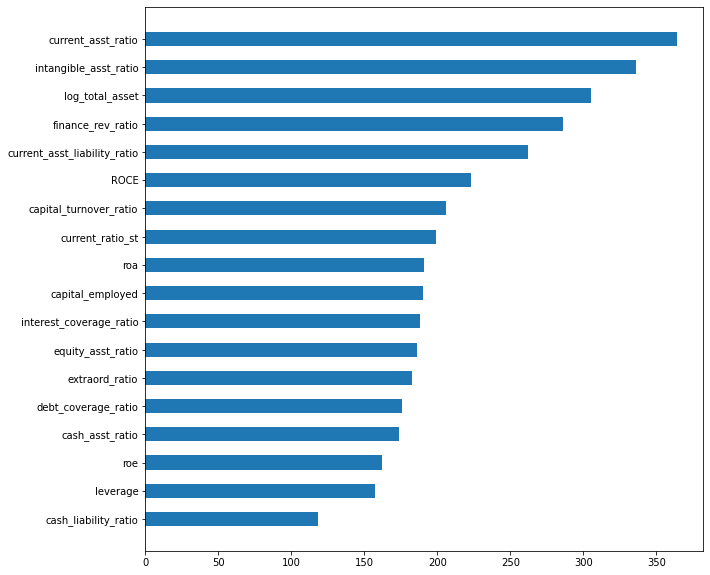

In [108]:
fea_imp = pd.DataFrame()
fea_imp['imp'] = clf.feature_importance()
fea_imp['fea_name'] = clf.feature_name()
fea_imp = fea_imp.sort_values('imp')[:30]
plt.figure(figsize=(10, 10))
plt.barh(fea_imp['fea_name'],fea_imp['imp'],height =0.5)

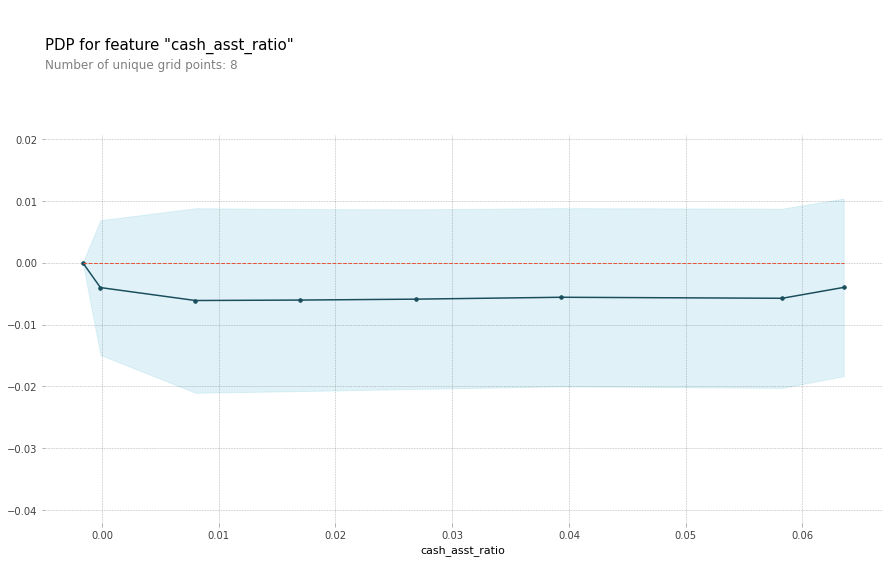

In [114]:
feat_name = 'cash_asst_ratio'
pdp_dist = pdp.pdp_isolate(model=clf, dataset = train, model_features=feature, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

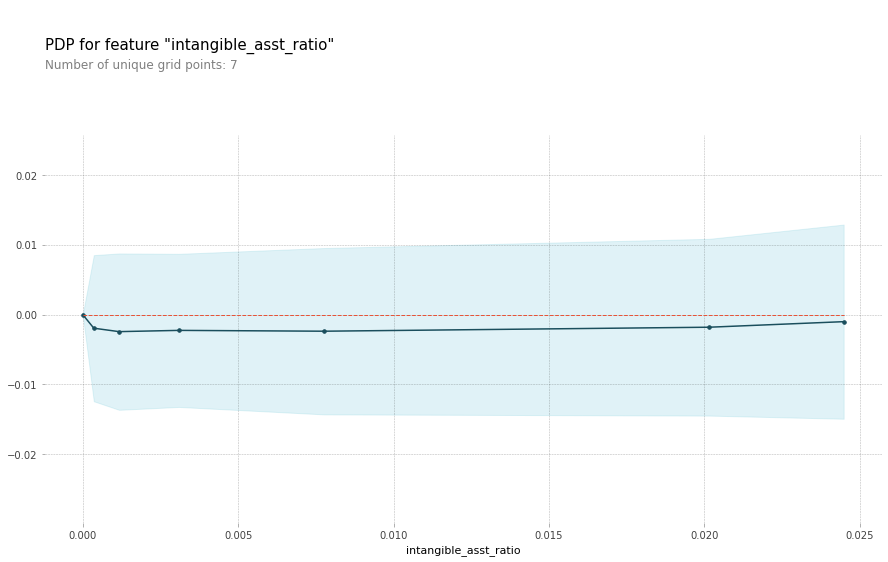

In [116]:
feat_name = 'intangible_asst_ratio'
pdp_dist = pdp.pdp_isolate(model=clf, dataset = train, model_features=feature, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()